In [1]:
import os
import random
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

## 加载数据

In [3]:
rootdir = os.getcwd()

In [5]:
filename = '\\dataset\\jena_climate_2009_2016.csv'
df = pd.read_csv(rootdir + filename)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
df.shape

(420551, 15)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


# 缺失的风速数据填充

In [9]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.00
wv[bad_wv] = 0.0

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3908\532371824.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wv[bad_wv] = 0.0


In [10]:
max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.00
max_wv[bad_max_wv] = 0.0

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3908\2277056218.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_wv[bad_max_wv] = 0.0


In [11]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [12]:
df['Date Time']

0         01.01.2009 00:10:00
1         01.01.2009 00:20:00
2         01.01.2009 00:30:00
3         01.01.2009 00:40:00
4         01.01.2009 00:50:00
                 ...         
420546    31.12.2016 23:20:00
420547    31.12.2016 23:30:00
420548    31.12.2016 23:40:00
420549    31.12.2016 23:50:00
420550    01.01.2017 00:00:00
Name: Date Time, Length: 420551, dtype: object

# 风速数据预处理

In [13]:
dfc = df.copy()

wv = dfc.pop('wv (m/s)')
max_wv = dfc.pop('max. wv (m/s)')
# 风向
wd_rad = dfc.pop('wd (deg)') * np.pi / 180

# 计算 wind x 和 wind y 分量
df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

# 计算 最大风速 x 和 y 分量
df['max Wx'] = max_wv * np.cos(wd_rad)
df['max Wy'] = max_wv * np.sin(wd_rad)

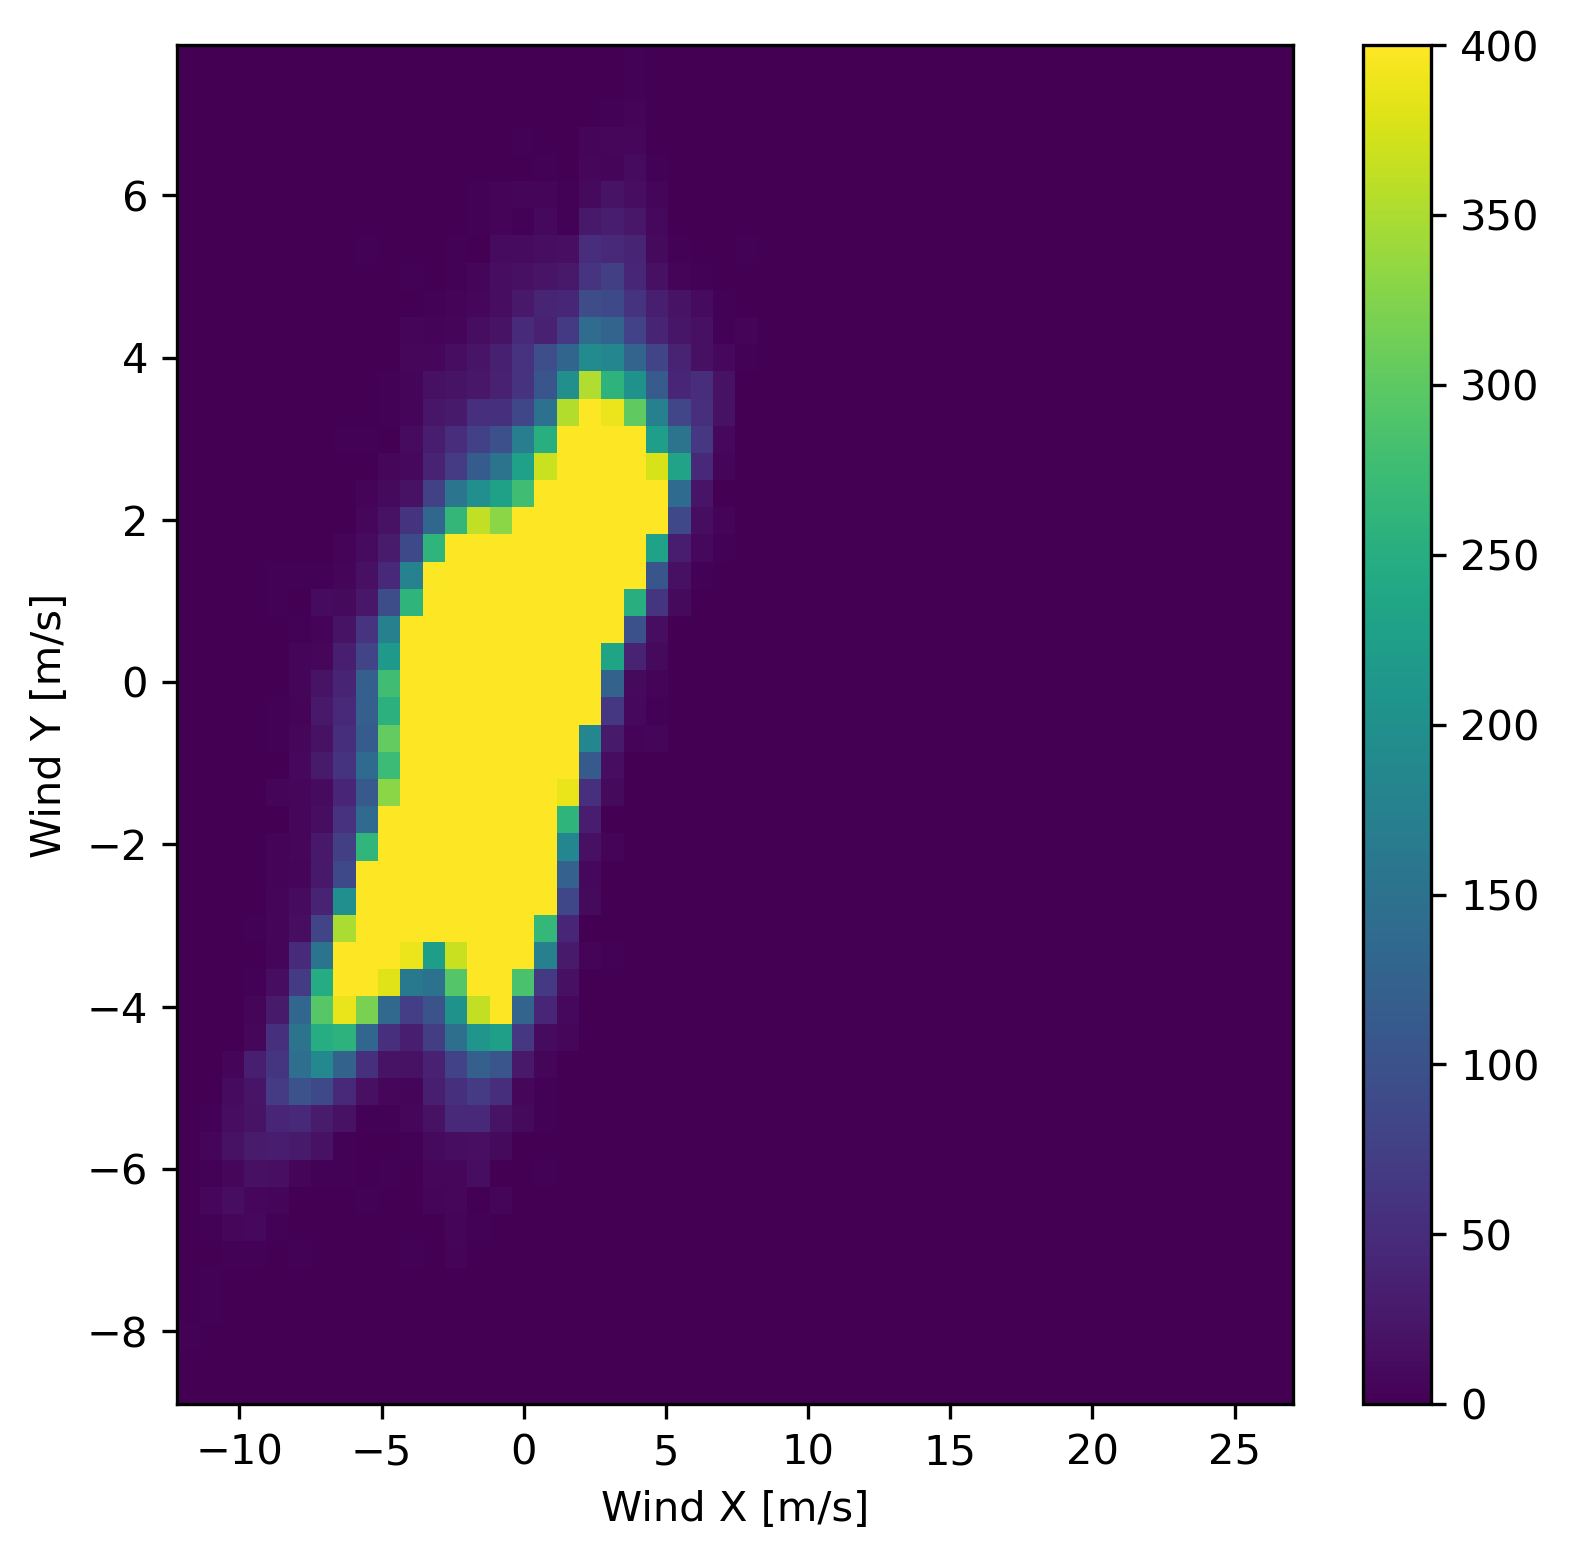

In [14]:
plt.figure(figsize=(6,6), dpi=300)
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

plt.savefig('wind_speed_distribution.png', dpi=300)

# 时间信息

In [15]:
import datetime
date_time = pd.to_datetime(dfc.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day = 24 * 60 * 60
year = (365.2425) * day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [16]:
# import tensorflow as tf

# fft = tf.signal.rfft(df['T (defC)'])
# f_per_dataset = np.range(0, len(fft))
# n_samples_h = len(df['T (degC)'])
# hours_per_year = 24 * 365.2524
# years_per_dataset = np_samples_h/ hours_per_year
# f_per_year = f_per_dataset / years_per_dataset

# plt.step(f_per_year, np.abs(fft))
# plt.xscale('log')
# plt.ylim(0, 400000)
# plt.xlim([0.1, max(plt.lim())])
# plt.xticks([1, 365.2524], ['1/Year', '1/day'])
# _ = plt.xlabel('Frequency(log scale)')

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.600000,984.200000,9.895800e+02,994.720000,1015.350000
T (degC),420551.0,9.450147,8.423365,-23.010000,3.360000,9.420000e+00,15.470000,37.280000
Tpot (K),420551.0,283.492743,8.504471,250.600000,277.430000,2.834700e+02,289.530000,311.340000
Tdew (degC),420551.0,4.955854,6.730674,-25.010000,0.240000,5.220000e+00,10.070000,23.110000
rh (%),420551.0,76.008259,16.476175,12.950000,65.210000,7.930000e+01,89.400000,100.000000
VPmax (mbar),420551.0,13.576251,7.739020,0.950000,7.780000,1.182000e+01,17.600000,63.770000
VPact (mbar),420551.0,9.533756,4.184164,0.790000,6.210000,8.860000e+00,12.350000,28.320000
VPdef (mbar),420551.0,4.042412,4.896851,0.000000,0.870000,2.190000e+00,5.300000,46.010000
sh (g/kg),420551.0,6.022408,2.656139,0.500000,3.920000,5.590000e+00,7.800000,18.130000
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.800000,6.290000,8.960000e+00,12.490000,28.820000


In [18]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos',
       'Year sin', 'Year cos'],
      dtype='object')

In [19]:
# 使用的特征
use_features = ['p (mbar)', 'VPmax (mbar)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'T (degC)']
# 使用30万条数据进行训练评估测试
use_data_rows = 300000

In [20]:
df_use = df[use_features].iloc[:use_data_rows, :]

In [21]:
df_use.tail()

,p (mbar),VPmax (mbar),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,T (degC)
299995,993.17,16.94,16.83,1193.56,2.699670,1.138720,3.980401,1.678932,14.87
299996,993.18,16.89,16.79,1193.75,2.640566,1.222910,3.665941,1.697786,14.83
299997,993.17,16.86,16.77,1193.88,2.601542,1.113948,4.164306,1.783103,14.80
299998,993.21,16.86,16.77,1193.93,2.489474,1.191688,3.644013,1.744355,14.80
299999,993.17,16.86,16.77,1193.88,2.224053,1.097264,3.049105,1.504314,14.80


In [22]:
df_save_features = ['Date Time', 'p (mbar)', 'VPmax (mbar)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'T (degC)']
df_save = df[df_save_features].iloc[:use_data_rows, :]

In [23]:
# 保存数据
df_save.to_csv(f'{rootdir}\\dataset\\processed_data.csv', index=False)

In [24]:
len(df_save.columns)

10